# Preparing the full set of data

In [2]:
import numpy as np
import scipy as sp
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup



dtres=pd.read_excel('data/ceda1996data.xls')

dfpres2016=pd.read_excel('data/2016_pres.xls')

for name in dfpres2016.columns:
    if '(W/I)' in dfpres2016.iloc[0][name]:
        del dfpres2016[name]
    elif name !='Votes not Cast':
        namepparty=dfpres2016.iloc[0][name]+'_2016'
        dfpres2016.rename(columns={name:namepparty},inplace=True)
    
dfpres2016=dfpres2016.drop(['  Percent',np.nan]).apply(lambda x: x/x.sum(), axis=1)


dfpres2012=pd.read_excel('data/2012_pres.xls')
for name in dfpres2012.columns:
    if '(W/I)' in dfpres2012.iloc[0][name]:
        del dfpres2012[name]
    elif  name !='Votes not Cast':
        namepparty=dfpres2012.iloc[0][name]+'_2012'
        dfpres2012.rename(columns={name:namepparty},inplace=True)
dfpres2012=dfpres2012.drop(['  Percent',np.nan]).apply(lambda x: x/x.sum(), axis=1)


dfpres2008=pd.read_excel('data/2008_pres.xls')
for name in dfpres2008.columns:
    if '(W/I)' in dfpres2008.iloc[0][name]:
        del dfpres2008[name]
    elif  name !='Votes not Cast':
        namepparty=dfpres2008.iloc[0][name]+'_2008'
        dfpres2008.rename(columns={name:namepparty},inplace=True)
dfpres2008=dfpres2008.drop(['  Percent',np.nan]).apply(lambda x: x/x.sum(), axis=1)


dfpres2004=pd.read_excel('data/2004_pres.xls')
for name in dfpres2004.columns:
    if name !='Votes not Cast' and '(W/I)' in dfpres2004.iloc[0][name]:
        del dfpres2004[name]
    elif  name !='Votes not Cast':
        namepparty=dfpres2004.iloc[0][name]+'_2004'
        dfpres2004.rename(columns={name:namepparty},inplace=True)
dfpres2004=dfpres2004.drop(['  Percent',np.nan]).apply(lambda x: x/x.sum(), axis=1)


dfpres2000=pd.read_excel('data/2000_pres.xlsx')
dfpres2000 = dfpres2000[dfpres2000.columns.drop(list(dfpres2000.filter(regex='Unnamed')))]
for name in dfpres2000.columns:
    if  name !='Votes not Cast':
        namepparty=name+'_2000'
        dfpres2000.rename(columns={name:namepparty},inplace=True)
dfpres2000=dfpres2000.dropna().drop(['Percent',np.nan]).apply(lambda x: x/x.sum(), axis=1)


    
for i in range(1997,2011):
    dfaux=pd.read_excel('data/ceda%sdata.xls'%i)

    dtres=pd.concat([dtres,dfaux])
    
for i in range(2011,2017):
    dfaux=pd.read_excel('data/ceda%sdata.xlsx'%i)

    dtres=pd.concat([dtres,dfaux])


    
dtres['PercentYes']=dtres['YES']/dtres['TOTAL']
dtres['PercentYesbinned']=pd.cut(dtres['PercentYes'],4)
dtres['OUTCOME']=-2*dtres['OUTCOME']+3
dtres['RECTOPNAME']=dtres['RECTOPNAME'].str.replace('.','')
dtres['CNTYNAME']=dtres['CNTYNAME'].str.lower().replace('toulumne','tuolumne').replace('san bernadino', 'san bernardino')


dictdfpres={'2000': dfpres2000,'2004': dfpres2004,'2008': dfpres2008,'2012': dfpres2012,'2016': dfpres2016}  



# Classification positive/negative BALQUEST

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
dfclass=dtres[dtres['RECTOPNAME'].isin(['Revenues: Tax Creation/Incr/Contin','Revenues: Tax Repeal/Reduction/Limit'])].replace({'RECTOPNAME':{'Revenues: Tax Creation/Incr/Contin':1,'Revenues: Tax Repeal/Reduction/Limit':-1}})
X_data=dfclass['BALQUEST'].dropna().str.lower().str.replace('city','').str.replace('charter','').str.replace('shall','').str.replace('should','').str.replace('county','').str.replace('\d+', '').str.replace('$', '').str.replace('no.', '')
dfTopic=dtres.dropna(axis=0,subset=['BALQUEST'])
dfTopic.set_index

#Train the vectorizer
dftext=dfTopic['BALQUEST'].str.lower().str.replace('bonds','').str.replace('city','').str.replace('charter','').str.replace('shall','').str.replace('should','').str.replace('county','').str.replace('\d+', '').str.replace('$', '').str.replace('no.', '')
fullcorpus=dftext.copy()
tvecfull = TfidfVectorizer(min_df=.0025, max_df=0.2, stop_words='english', ngram_range=(1,1))
tvecfull.fit(fullcorpus)

#Train the classifier
X_datavec= tvecfull.transform(X_data)
y_data=dfclass['RECTOPNAME']
X_train, X_test, y_train, y_test = train_test_split(X_datavec, y_data,random_state=20)
clf = GradientBoostingClassifier(learning_rate = 0.08, max_depth = 3, random_state = 0,n_estimators=40).fit(X_train, y_train)
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'     .format(clf.score(X_test, y_test)))

fullcorpus_vec=tvecfull.transform(fullcorpus)
Solpredict=clf.predict(fullcorpus_vec)

Accuracy of Decision Tree classifier on training set: 0.96
Accuracy of Decision Tree classifier on test set: 0.92


# Classification Topic Balquest

In [4]:
from sklearn.preprocessing import StandardScaler
labels=['education','safety','health','facilities','recall','tourism']


for name in np.unique(dtres['CNTYNAME'].values):
        dftext=dftext.str.replace(name,'')
    
for name in np.unique(dtres['PLACE'].str.lower().values):
        dftext=dftext.str.replace(name,'')



fulldf=dfTopic.copy()
fulldf['TopicName']='notopic'
fulldf['PosNeg']=Solpredict
fulldf.loc[fulldf['PosNeg']==-1,'PercentYes']=1-fulldf[fulldf['PosNeg']==-1]['PercentYes']

fulldf.loc[(fulldf['RECTOPNAME'].str.lower().str.contains('governance'))|(fulldf['RECTOPNAME'].str.lower().str.contains('zoning'))|(fulldf['RECTOPNAME'].str.lower().str.contains('land')),'TopicName']='other'

for term in labels:
    exclu="|".join(np.setxor1d(labels, [term]))
    fulldf.loc[(dftext.str.contains(term))&(dftext.str.contains(exclu)==False),'TopicName']=term


tvec = TfidfVectorizer(min_df=.0015, max_df=0.07, stop_words='english', ngram_range=(2,2))
tvec_weights = tvec.fit_transform(dftext)
tvocab=np.array(tvec.get_feature_names())

X_datatop=fulldf.loc[(fulldf['TopicName']!='notopic')]['BALQUEST']
X_datatop_vec=pd.DataFrame(tvec.transform(X_datatop).todense(), columns=tvocab,index=X_datatop.index)
y_datatop=fulldf.loc[(fulldf['TopicName']!='notopic'),'TopicName']


X_remain=fulldf.loc[(fulldf['TopicName']=='notopic')]['BALQUEST']
X_remain_vec=pd.DataFrame(tvec.transform(X_remain).todense(), columns=tvocab,index=X_remain.index)

# Fitting the Classifier

scaler = StandardScaler()

X_traintop, X_testtop, y_traintop, y_testtop = train_test_split(X_datatop_vec, y_datatop,random_state=20)

scaler.fit(X_traintop)


X_trainpost=scaler.transform(X_traintop)
X_testpost=scaler.transform(X_testtop)


clftop = RandomForestClassifier(n_estimators=200,max_features = 10,random_state=0).fit(X_trainpost, y_traintop)#GradientBoostingClassifier(learning_rate = 0.1, max_depth = 6, random_state = 0,n_estimators=60).fit(X_trainpost, y_traintop)
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clftop.score(X_trainpost, y_traintop)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'     .format(clftop.score(X_testpost, y_testtop)))

topredict=scaler.transform(X_remain_vec)

oldfulldf=fulldf.copy()

fulldf.loc[fulldf['TopicName']=='notopic','TopicName']=clftop.predict(topredict)


Accuracy of Decision Tree classifier on training set: 0.99
Accuracy of Decision Tree classifier on test set: 0.89


Repartion of labels

In [5]:
fulldf.groupby(['TopicName']).agg({'OUTCOME':np.size})

,OUTCOME
TopicName,
education,841
facilities,2191
health,70
other,3856
recall,334
safety,1292
tourism,228


In [10]:
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
#Function that computes the label for a given period [Yearmin,Yearmax] and number of cluster n_clust given the fata fulldf

def computelabel(Yearmin,Yearmax,fulldf,nclust=2):
 
    dfred=fulldf[(fulldf['YEAR']>=Yearmin)&(fulldf['YEAR']<=Yearmax)].dropna(axis=0,subset=['BALQUEST'])#[(dtres['RECTOPNAME'] == 'Education: Bonds')| (dtres['RECTOPNAME'] == 'Revenues: Tax Creation/Incr./Contin.') | (dtres['RECTOPNAME'] == 'Education')]
    dfpres=dictdfpres[str(Yearmax)].copy()

    dfpres.index=dfpres.index.str.lower()

    dfpres['Winner']=dfpres.idxmax(axis=1).str[:3]
    dfpres=dfpres.replace({'Winner':{'REP':-1,'DEM':1}})
    
    dfClustermean =dfred.groupby(['CNTYNAME','TopicName']).agg({'PercentYes':[np.mean]})
    dfClustermean.columns=dfClustermean.columns.droplevel(0)

    dictval=[]
    indcnty=0
    for cnty in np.unique(dfClustermean.reset_index()['CNTYNAME'].values):
        dictval.append({})
        for topname in dfClustermean.loc[cnty].index:
            for label in dfClustermean.columns:
                dictval[indcnty][topname]=dfClustermean.loc[cnty,topname][label]
        
        indcnty+=1

    dfCNTYmean=pd.DataFrame(dictval,index=np.unique(dfClustermean.reset_index()['CNTYNAME'].values)).replace(np.nan,0.5)


    Y_sklearn = pd.DataFrame(scaler.fit_transform(dfCNTYmean),columns=dfCNTYmean.columns,index=dfCNTYmean.index)#pd.DataFrame(sklearn_pca.fit_transform(scaler.fit_transform(dfCNTYmean)),index=dfCNTYmean.index)#scaler.fit_transform(dfCNTYmean)
    

    Y_PCAmerge=pd.merge(Y_sklearn,dfpres[np.setxor1d(dfpres.columns, ['Winner'])],left_index=True,right_index=True)



    kmeans = KMeans(n_clusters=nclust, random_state=0,n_init=30,max_iter=1000).fit(scaler.fit_transform(Y_PCAmerge))
    SeriesLabel=pd.Series(kmeans.labels_,index=Y_PCAmerge.index)
    Y_PCAmerge['Label']=SeriesLabel.replace(to_replace=np.nan,value=nclust)
    
    dfCNTYmerge=pd.merge(Y_PCAmerge,dfpres,how='left',left_index=True,right_index=True)
    changelabel={np.array([ dfCNTYmerge[dfCNTYmerge['Label']==i]['Winner'].mean() for i in range(nclust)]).argsort()[::-1][l]: 'Lab%s'%l for l in range(nclust)}

    dfCNTYmerge=dfCNTYmerge.replace({"Label": changelabel})#.replace({"Label": {'Lab%s'%i :i for i in range(nclust)}})
    dfCNTYmean['Label']=dfCNTYmerge['Label']
    order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
    terms = Y_PCAmerge.columns
    clusterlabels={}
    for i in range(nclust):
        clusterlabels[changelabel[i]]={}
        for ind in order_centroids[i, :]:
            clusterlabels[changelabel[i]][terms[ind]]=kmeans.cluster_centers_[i,ind]
    dfclustlabel=pd.DataFrame.from_dict(clusterlabels,orient='index')
    dfCNTYmerge[labels]=dfCNTYmerge[labels]-dfCNTYmerge[labels].min()
    dfCNTYmerge[labels]=dfCNTYmerge[labels]/dfCNTYmerge[labels].max()

    
    return [dfCNTYmerge,dfCNTYmean,dfclustlabel]

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
from math import pi

def plotspider(df,color,label,lw=2,alpha=0.8,ls='-'):
# number of variable
    categories=df.index
    N = len(categories)
 
# We are going to plot the first line of the data frame.
# But we need to repeat the first value to close the circular graph:
    values=df.values.tolist()
    values += values[:1]
    values
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
 
# Initialise the spider plot
    ax = plt.subplot(111, polar=True)
 
# Draw one axe per variable + add labels labels yet
    plt.xticks(np.array(angles[:-1]), categories, color='black', size=18)
 
# Draw ylabels
    ax.set_rlabel_position(160)
    plt.yticks([0,0.25,0.5,0.75,1], ["0",'',"0.5",'',"1"], color="black", size=18)
    plt.ylim(0,1)
 
# Plot data
    ax.plot(angles, values, linewidth=lw, linestyle='solid',color=color,label=label,alpha=alpha,ls=ls)
    ax.plot(np.linspace(0.0, 2*np.pi,100), 0.5*np.ones(100),color='grey',alpha=0.6,lw=2,ls='--') 
 
# Fill area
    ax.fill(angles, values, color, alpha=0.)
    
    return ax


Example spider plot for period 2008-2012 and 2 clusters

/Users/jgleyzes/anaconda2/lib/python2.7/site-packages/matplotlib/cbook.py:2649: UserWarning: Saw kwargs [u'ls', u'linestyle'] which are all aliases for u'linestyle'.  Kept value from u'linestyle'
  seen=seen, canon=canonical, used=seen[-1]))


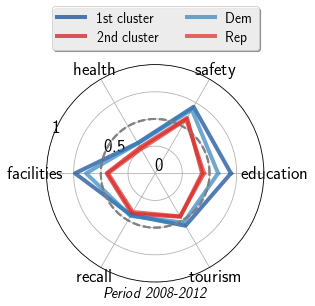

In [11]:
dfCNTYmerge,dfCNTYmean,dfclustlabel=computelabel(2008,2012,fulldf,nclust=2)
from matplotlib import rc
rc('text', usetex=True)
colorlabel={'Strong REP':'#cb181d','Strong DEM':'#084594','Outliers REP':'#cb181d','Outliers DEM':'#4292c6','Lab3':'#FFFFFF'}
Winnertopres={'1':'Dem','-1':'Rep'}
propDEMdic={}
arraypropDEM=[float(dfCNTYmerge.loc[(dfCNTYmerge['Label']==label)&(dfCNTYmerge['Winner']==1)].shape[0])/dfCNTYmerge.loc[(dfCNTYmerge['Label']==label),'Winner'].shape[0] for label in np.unique(dfCNTYmerge['Label'].values)]
for label in np.unique(dfCNTYmerge['Label'].values):
        propDEM=float(dfCNTYmerge.loc[(dfCNTYmerge['Label']==label)&(dfCNTYmerge['Winner']==1)].shape[0])/dfCNTYmerge.loc[(dfCNTYmerge['Label']==label),'Winner'].shape[0] 
        if propDEM>=np.array(arraypropDEM).max():
            labelname='Strong DEM'
        elif propDEM>0.5 and propDEM<=np.array(arraypropDEM).max():
            labelname= 'Outliers DEM'
        elif propDEM>np.array(arraypropDEM).min() and propDEM<=0.5:
            labelname= 'Outliers REP'
        else:
            labelname= 'Strong REP'
        propDEMdic[label]=labelname
plt.clf()
plotspider(dfCNTYmerge.loc[dfCNTYmerge['Label']=='Lab0',labels].mean(),colorlabel[propDEMdic['Lab0']],'1st cluster',lw=4,alpha=0.7)
plotspider(dfCNTYmerge.loc[dfCNTYmerge['Label']=='Lab1',labels].mean(),colorlabel[propDEMdic['Lab1']],'2nd cluster',lw=4,alpha=0.7)

plotspider(dfCNTYmerge.loc[dfCNTYmerge['Winner']==1,labels].mean(),'#3182BD','Dem',lw=4,alpha=0.7)
plotspider(dfCNTYmerge.loc[dfCNTYmerge['Winner']==-1,labels].mean(),'#DE2D26','Rep',lw=4,alpha=0.7)

plt.xlabel(r'  \begin{center}\vspace{10cm}\textit{\Large{' + 'Period 2008-2012' + r'}}\end{center}')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3),
          fancybox=True, shadow=True, ncol=2,fontsize=14)
#plt.savefig('data/figtest.png')
plt.show()

# Plotting on the map

Preparing the JSON data

In [56]:
import json
import pandas as pd
from matplotlib import rc
rc('text', usetex=True)

with open('data/Cacountiesconvert.json', 'r') as f:
    get_id = json.load(f)

#A little FIPS code type casting to ensure keys match
new_geoms = []
for geom in get_id['features']:
    geom['properties']['NAME'] = geom['properties']['NAME'].lower()
    new_geoms.append(geom)

get_id['features'] = new_geoms

with open('data/Cacountiesconvert.json', 'w') as f:
    json.dump(get_id, f)
geo_json_data = json.load(open('data/Cacountiesconvert.json'))
dflocfull=pd.read_csv('data/countiescapital.csv').rename(columns={'County [2]':'NAME'})
dflocfull['NAME']=dflocfull['NAME'].str.lower()
dfloc=dflocfull[dflocfull['State']=='CA'][['NAME','Latitude','Longitude']].set_index('NAME')
dfloc['Latitude']=pd.to_numeric(dfloc['Latitude'].str[:8])
dfloc['Longitude']=-pd.to_numeric(dfloc['Longitude'].str[3:12])

In [105]:
import folium
import base64
from folium.element  import IFrame
def my_color_function(df,feature):
        if float(df.loc[feature['properties']['NAME'],'Winner']) > 0:
            return '#3182BD'
        else:
            return '#DE2D26'

colorlabel={'Strong REP':'#cb181d','Strong DEM':'#084594','Outliers REP 2nd':'#fe9929','Outliers REP':'#d6604d','Outliers DEM 2nd':'#1c9099','Outliers DEM':'#4292c6','Labn':'#FFFFFF'}
Winnertopres={1:'Dem',-1:'Rep'}
map_1 = folium.Map([35,-120], tiles='Mapbox Bright', zoom_start=5)

nclust=2


dfpres1=dictdfpres[str(2004)].copy()
dfpres1.index=dfpres1.index.str.lower() 
dfpres1['Winner']=dfpres1.idxmax(axis=1).str[:3]
dfpres1=dfpres1.replace({'Winner':{'REP':-1,'DEM':1}})
map_1.add_child(folium.GeoJson(geo_json_data ,
    style_function=lambda feature: {
        'fillColor': my_color_function(dfpres1,feature),
        'color' : 'black',
        'weight' : 2,
        'dashArray' : '5, 5',
        'fillOpacity':0.9
        },name='{} Presidential Elections'.format(2004)))

dfpres2=dictdfpres[str(2008)].copy()
dfpres2.index=dfpres2.index.str.lower() 
dfpres2['Winner']=dfpres2.idxmax(axis=1).str[:3]
dfpres2=dfpres2.replace({'Winner':{'REP':-1,'DEM':1}})
map_1.add_child(folium.GeoJson(geo_json_data ,
    style_function=lambda feature: {
        'fillColor': my_color_function(dfpres2,feature),
        'color' : 'black',
        'weight' : 2,
        'dashArray' : '5, 5',
        'fillOpacity':0.9
        },name='{} Presidential Elections'.format(2008)))

dfpres3=dictdfpres[str(2012)].copy()
dfpres3.index=dfpres3.index.str.lower() 
dfpres3['Winner']=dfpres3.idxmax(axis=1).str[:3]
dfpres3=dfpres3.replace({'Winner':{'REP':-1,'DEM':1}})
map_1.add_child(folium.GeoJson(geo_json_data ,
    style_function=lambda feature: {
        'fillColor': my_color_function(dfpres3,feature),
        'color' : 'black',
        'weight' : 2,
        'dashArray' : '5, 5',
        'fillOpacity':0.9
        },name='{} Presidential Elections'.format(2012)))

dfpres4=dictdfpres[str(2016)].copy()
dfpres4.index=dfpres4.index.str.lower()
dfpres4['Winner']=dfpres4.idxmax(axis=1).str[:3]
dfpres4=dfpres4.replace({'Winner':{'REP':-1,'DEM':1}})
map_1.add_child(folium.GeoJson(geo_json_data ,
    style_function=lambda feature: {
        'fillColor': my_color_function(dfpres4,feature),
        'color' : 'black',
        'weight' : 2,
        'dashArray' : '5, 5',
        'fillOpacity':0.9
        },name='{} Presidential Elections'.format(2016)))

for Yearmax in [2004,2008,2012,2016]:
    
    dfCNTYmerge,dfCNTYmean,dfclustlabel=computelabel(Yearmax-4,Yearmax,fulldf,nclust=nclust)
    
    dfCNTYmerged=pd.merge(dfCNTYmerge,dfloc,how='outer',left_index=True,right_index=True)
    dfCNTYmerged['Label'].replace(np.nan,'Labn',inplace=True)
    
    dfpres=dictdfpres[str(Yearmax)].copy()
    dftot=dfCNTYmerge[labels].mean()
    dfpres.index=dfpres.index.str.lower()
    
    dfpres['Winner']=dfpres.idxmax(axis=1).str[:3]
    dfpres=dfpres.replace({'Winner':{'REP':-1,'DEM':1}})
    dfclustlabel
    
    propDEMdic={}
    arraypropDEM=[dfclustlabel.loc[label,'DEM_%s'%Yearmax] for label in np.unique(dfCNTYmerge['Label'].values)]
    strDEM=''
    strREP=''
    for label in np.unique(dfCNTYmerge['Label'].values):
        propDEM=dfclustlabel.loc[label,'DEM_%s'%Yearmax] 
        if propDEM>=np.array(arraypropDEM).max():
            labelname='Strong DEM'
        elif propDEM>0 and propDEM<np.array(arraypropDEM).max():
            labelname= 'Outliers DEM'+strDEM
            strDEM+=' 2nd'
        elif propDEM>np.array(arraypropDEM).min() and propDEM<=0:
            labelname= 'Outliers REP'+strREP
            strREP+=' 2nd'
        else:
            labelname= 'Strong REP'
        propDEMdic[label]=labelname
    for name in dfCNTYmerged[dfCNTYmerged['Winner'].isnull()].index:
        dfCNTYmerged.loc[name,'Winner']=dfpres.loc[name,'Winner']
    for name in dfCNTYmerge.index:
        plt.clf()
        label=dfCNTYmerge.loc[name,'Label']
        
        labelname= propDEMdic[label]   
        dname=dfCNTYmerge.loc[name,labels]
        
        txt='{} county voted {} in {}, belongs to category {}'.format(name.title(),Winnertopres[int(dfCNTYmerged.loc[name,'Winner'])]
                                                                  ,Yearmax,labelname)
                    
        dlabel=dfCNTYmerge[dfCNTYmerge['Label']==label][labels].mean()
        labelname=propDEMdic[label]
        plotspider(dlabel,colorlabel[labelname],labelname,lw=3,alpha=0.7)
        plotspider(dftot,'black','Total',lw=3,alpha=0.7)
        plotspider(dname,'#8c510a',name.title(),lw=4,alpha=1)
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3),
                  fancybox=True, shadow=True, ncol=3,fontsize=14)
        plotspider(dname,'#8c510a',name.title(),lw=4,alpha=0)
        plt.xlabel(r'  \begin{center}\vspace{10cm}\textit{\Large{' + txt + r'}}\end{center}')
        
        plt.savefig('data/Figs/figspidercounty_%syear_%sclust_%s.png'%(name,Yearmax,nclust), bbox_inches='tight')
    
    
    layermarker=folium.FeatureGroup(name = 'Categories Year {}'.format(Yearmax))
    
    for name in dfCNTYmerged.index:
        label=dfCNTYmerged.loc[name,'Label']
        
        
        if label=='Labn':
            layermarker.add_children( folium.RegularPolygonMarker([dfCNTYmerged.loc[name,'Latitude'], dfCNTYmerged.loc[name,'Longitude']],
              popup='{} county voted {} in {}, belongs to category {}'.format(name.title(),Winnertopres[int(dfCNTYmerged.loc[name,'Winner'])]
                                                                  ,Yearmax,'no info'),
              number_of_sides=4,
                radius=10,fill_color=colorlabel[label], fill_opacity= 1,opacity=0
             ))
        else:
            labelname=propDEMdic[label]
            
            Filename='data/Figs/figspidercounty_%syear_%sclust_%s.png'%(name,Yearmax,nclust)
            encoded = base64.b64encode(open(Filename, 'rb').read())
            resolution, width, height = 30, 16, 10.5
            html = '<img src="data:image/png;base64,{}">'.format
            iframe = IFrame(html(encoded), width=(width*resolution)+10, height=(height*resolution)+10)
            popup=folium.Popup(iframe, max_width=2650)
            layermarker.add_children(folium.RegularPolygonMarker([dfCNTYmerged.loc[name,'Latitude'], dfCNTYmerged.loc[name,'Longitude']],
              popup=popup,
              number_of_sides=4,
                radius=10,fill_color=colorlabel[labelname], fill_opacity= 1,opacity=0))
        map_1.add_children(layermarker)


folium.LayerControl().add_to(map_1)    

map_1.save('data/map%s.html'%nclust)